# QLearning using table

In QLearning we build table which stores future rewards for each states and actions.
In this notebook we will implement Learning Agent using Q Learning function with Q Table for storing rewards.

For this tutorial we will use [Frozen Lake](https://gym.openai.com/envs/FrozenLake-v0).

```
SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)
```

This is a stochastic environment, because wind can change the state we will end up.

In [27]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import wrappers

logging.getLogger('gym').setLevel(logging.WARNING)

## Helper functions

In [28]:
# FrozenLake is solved if moving average over window size 100 is >= 0.78
def moving_average(xs, n=100):
    ret = np.cumsum(xs, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def find_index(xs, v):
    """Find index of the first value equal or greater then v"""
    for i in range(len(xs)):
        if xs[i] >= v:
            return i
    return -1

## Load environment

In [29]:
env = gym.make('FrozenLake-v0')
env = wrappers.Monitor(env, '../logs/qtable', force=True)
print('Number of actions: {}'.format(env.action_space.n))
print('Number of states: {}'.format(env.observation_space.n))

Number of actions: 4
Number of states: 16


## Q Table Agent

This agent uses [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation) to improve Q Table

$$Q(s,a) = r + \gamma (max_a(Q(s', a'))$$

The update step uses the formula:

$$Q(s,a) = Q(s,a) + \alpha (r + \gamma (max_a(Q(s', a')) - Q(s,a))$$

In [30]:
class QTableAgent:
    
    def __init__(self, num_states, num_actions, gamma, learning_rate):
        self.qtable = np.zeros([num_states, num_actions])
        self.greedy_threshold = 0.9
        self.gamma = gamma
        self.alpha = learning_rate
    
    
    def choose_action(self, state, step):
        """ Choose best action (exploit) with the probability **greedy_threshold**
            Otherwise choose random action.
            The threshold is bigger for later episodes
        """
        if np.random.rand() < self.greedy_threshold * (step/1000.):
            return np.argmax(self.qtable[state,:])
        else:
            return np.random.choice(range(4))
    
    
    def learn(self, state, action, reward, next_state):
        """Update state using Bellman equation"""
        r2 = reward + self.gamma * np.max(self.qtable[next_state,:])
        self.qtable[state, action] += self.alpha * (r2-self.qtable[state, action])

## Train agent

Solved after 2096 episodes


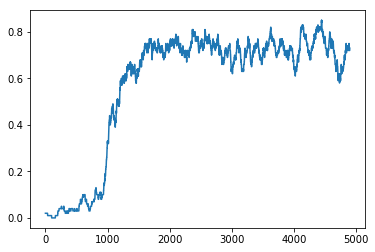

In [31]:
# Learning parameters
learning_rate = 0.8
gamma = 0.95
num_episodes = 5000

# Agent
agent = QTableAgent(env.observation_space.n, env.action_space.n, gamma, learning_rate)

# Learn Q-Table
rewards = []
for episode in range(num_episodes):
    s = env.reset()
    total_reward = 0
    for j in range(100):
        a = agent.choose_action(s, episode)
        s2, reward, done, _ = env.step(a)
        agent.learn(s, a, reward, s2)
        s = s2
        total_reward += reward
        if done:
            break
    rewards.append(total_reward)

# Show summary
averaged_rewards = moving_average(rewards)    
idx = find_index(averaged_rewards, 0.78)
if idx >= 0:
    print('Solved after {} episodes'.format(idx+1))

plt.plot(averaged_rewards)
plt.show()